# PJM Hourly Energy Consumption EDA & Forecasting

## Setup and Data Loading

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [52]:
os.chdir("/Users/estellepan/Desktop/Data_Project/Energy_Consumption/png")

In [73]:
# Plot theme (keep consistent across notebook)
plt.rcParams["figure.figsize"] = (22, 10)   
plt.rcParams["figure.dpi"] = 150
ax.tick_params(axis='x', labelsize=14)  
ax.tick_params(axis='y', labelsize=14)  
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.alpha"] = 0.30
palette = sns.color_palette("Set2")

In [33]:
DATA_DIR = Path("/Users/estellepan/Desktop/PJM")
EAST_FILE = DATA_DIR / "PJME_hourly.csv" 
WEST_FILE = DATA_DIR / "PJMW_hourly.csv"   
df_all = pd.read_parquet('/Users/estellepan/Desktop/PJM/est_hourly.paruqet')

In [5]:
# Loader with cleaning
def load_pjm_csv(path: Path, value_col: str, new_name: str) -> pd.DataFrame:
    """
    Load a PJM hourly CSV, parse datetime, set index, sort, drop exact duplicate
    timestamps, reindex to regular hourly frequency, and time-interpolate gaps.
    """
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")

    df = pd.read_csv(
        path,
        parse_dates=["Datetime"],
        infer_datetime_format=True
    ).rename(columns={value_col: new_name})

    # Index by Datetime
    df = df.set_index("Datetime").sort_index()

    # Drop duplicate timestamps (keep first)
    if df.index.duplicated().any():
        df = df[~df.index.duplicated(keep="first")]

    # Build complete hourly index and align
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="H")
    df = df.reindex(full_idx)

    # Interpolate missing hourly points (linear-in-time)
    df = df.interpolate(method="time")

    # Final touch
    df.index.name = "Datetime"
    return df

In [6]:
df_east = load_pjm_csv(EAST_FILE, value_col="PJME_MW", new_name="East_MW")
df_west = load_pjm_csv(WEST_FILE, value_col="PJMW_MW", new_name="West_MW")

In [7]:
start = max(df_east.index.min(), df_west.index.min())
end   = min(df_east.index.max(), df_west.index.max())
common_idx = pd.date_range(start, end, freq="H")

df = (
    df_east.reindex(common_idx)[["East_MW"]]
    .join(df_west.reindex(common_idx)[["West_MW"]], how="inner")
)

## Exploratory Data Analysis (EDA)

The dataset contains over 143,000 hourly records of electricity load from April 2002 to August 2018. 
The East region is substantially larger in terms of demand compared to the West region and other regions. Before modeling, it is important to understand the distribution of loads to identify skewness, outliers, and potential seasonality.

In [35]:
df_all.describe().T

,count,mean,std,min,25%,50%,75%,max
AEP,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.00,25695.0
COMED,66497.0,11420.152112,2304.139517,7237.0,9780.0,11152.0,12510.00,23753.0
DAYTON,121275.0,2037.851140,393.403153,982.0,1749.0,2009.0,2279.00,3746.0
DEOK,57739.0,3105.096486,599.859026,907.0,2687.0,3013.0,3449.00,5445.0
DOM,116189.0,10949.203625,2413.946569,1253.0,9322.0,10501.0,12378.00,21651.0
DUQ,119068.0,1658.820296,301.740640,1014.0,1444.0,1630.0,1819.00,3054.0
EKPC,45334.0,1464.218423,378.868404,514.0,1185.0,1386.0,1699.00,3490.0
FE,62874.0,7792.159064,1331.268006,0.0,6807.0,7700.0,8556.00,14032.0
NI,58450.0,11701.682943,2371.498701,7003.0,9954.0,11521.0,12896.75,23631.0
PJME,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.00,62009.0


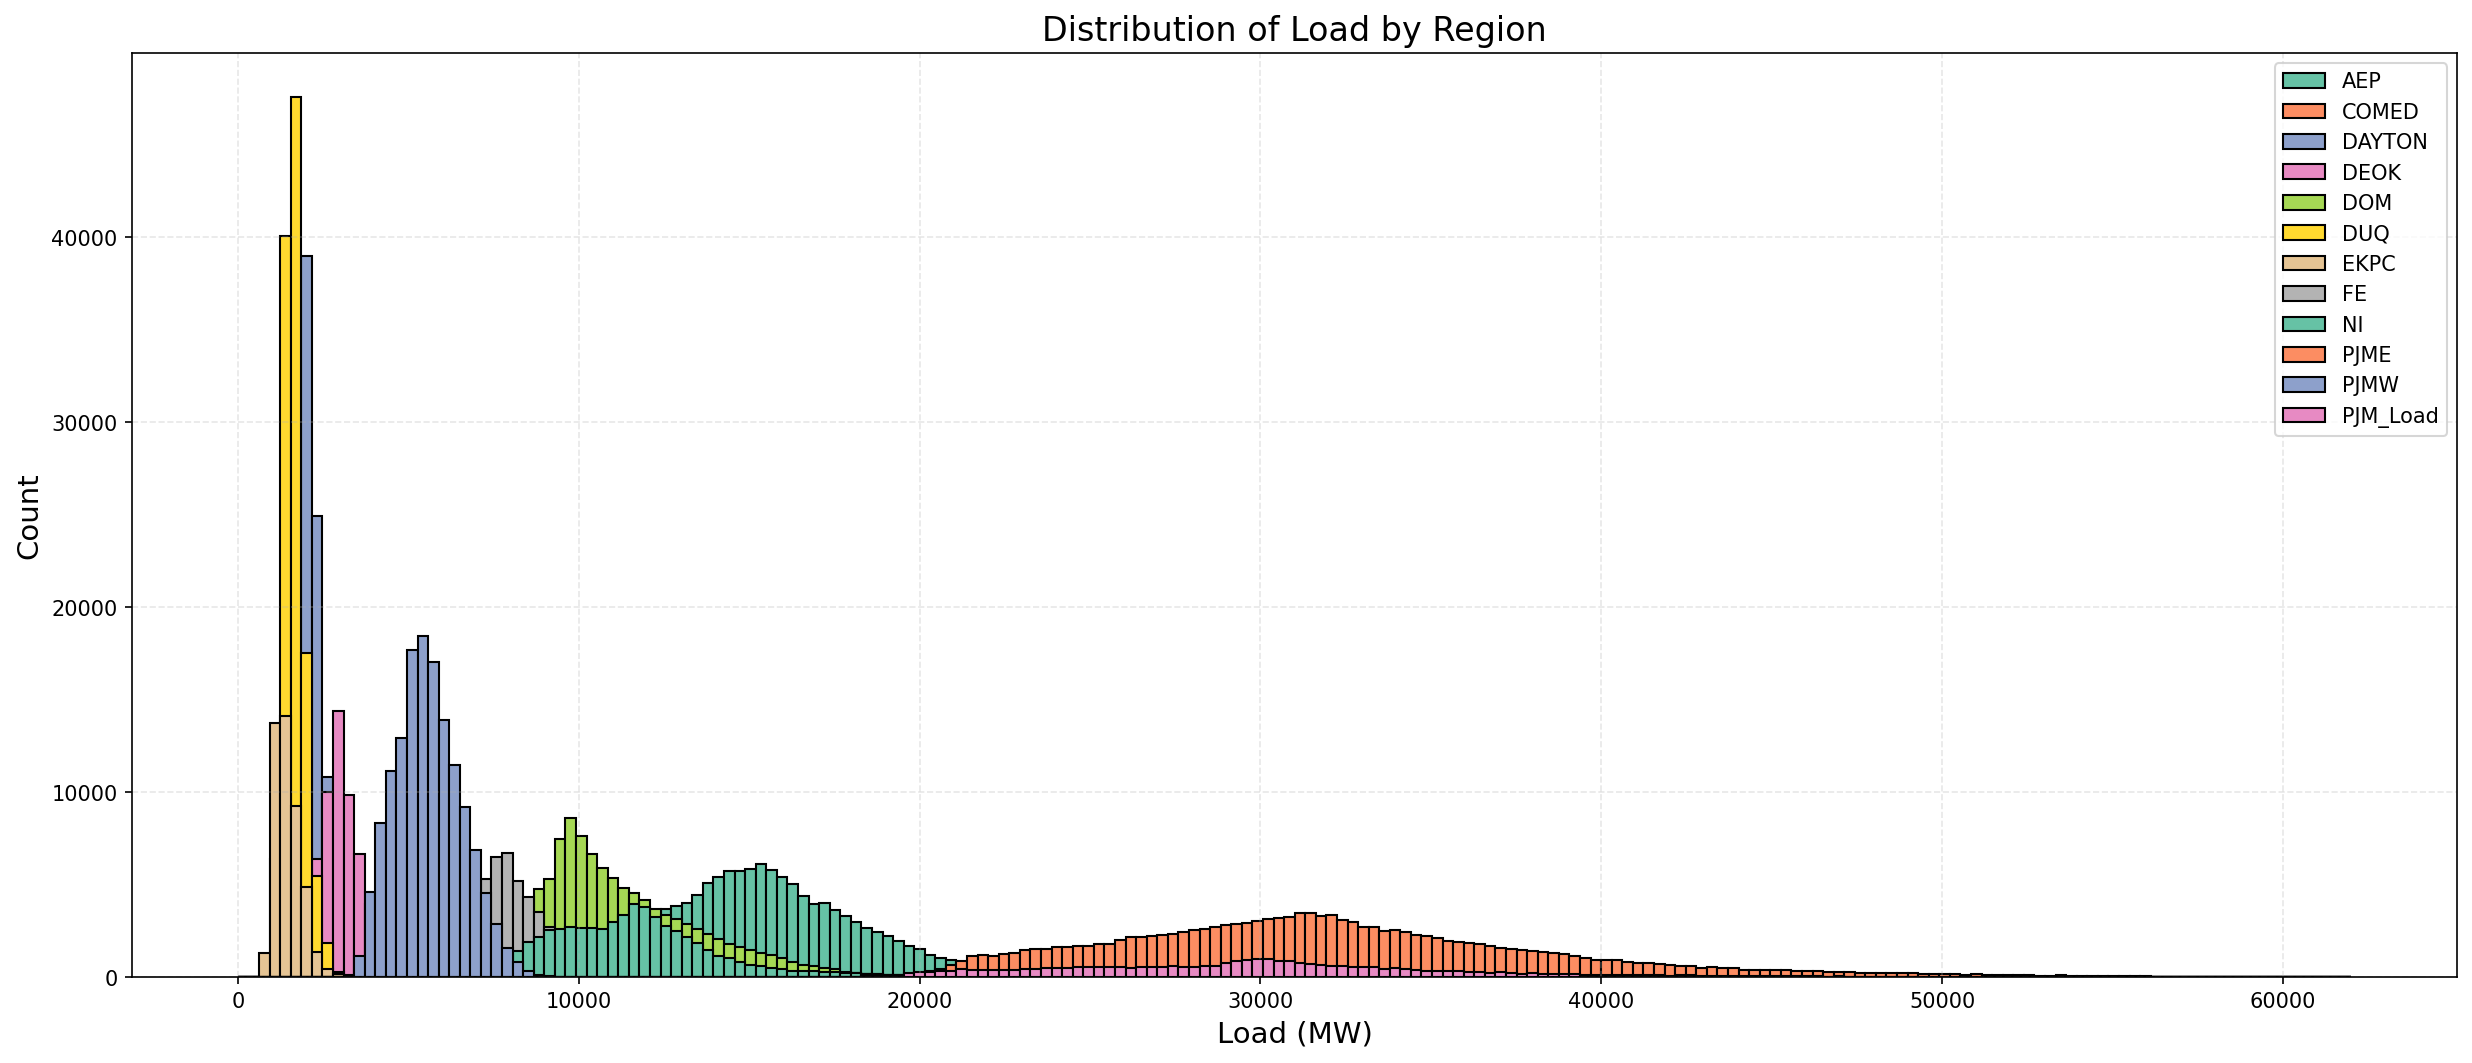

In [66]:
ax = df_all.plot.hist(
    bins=200,
    alpha=1.0,                 
    color=palette,             
    edgecolor="black",         
    figsize=(20,8)          
)

ax.set_title("Distribution of Load by Region", fontsize=16)
ax.set_xlabel("Load (MW)", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
plt.savefig("distribution_load_by_region.png", 
            dpi=300, bbox_inches="tight")

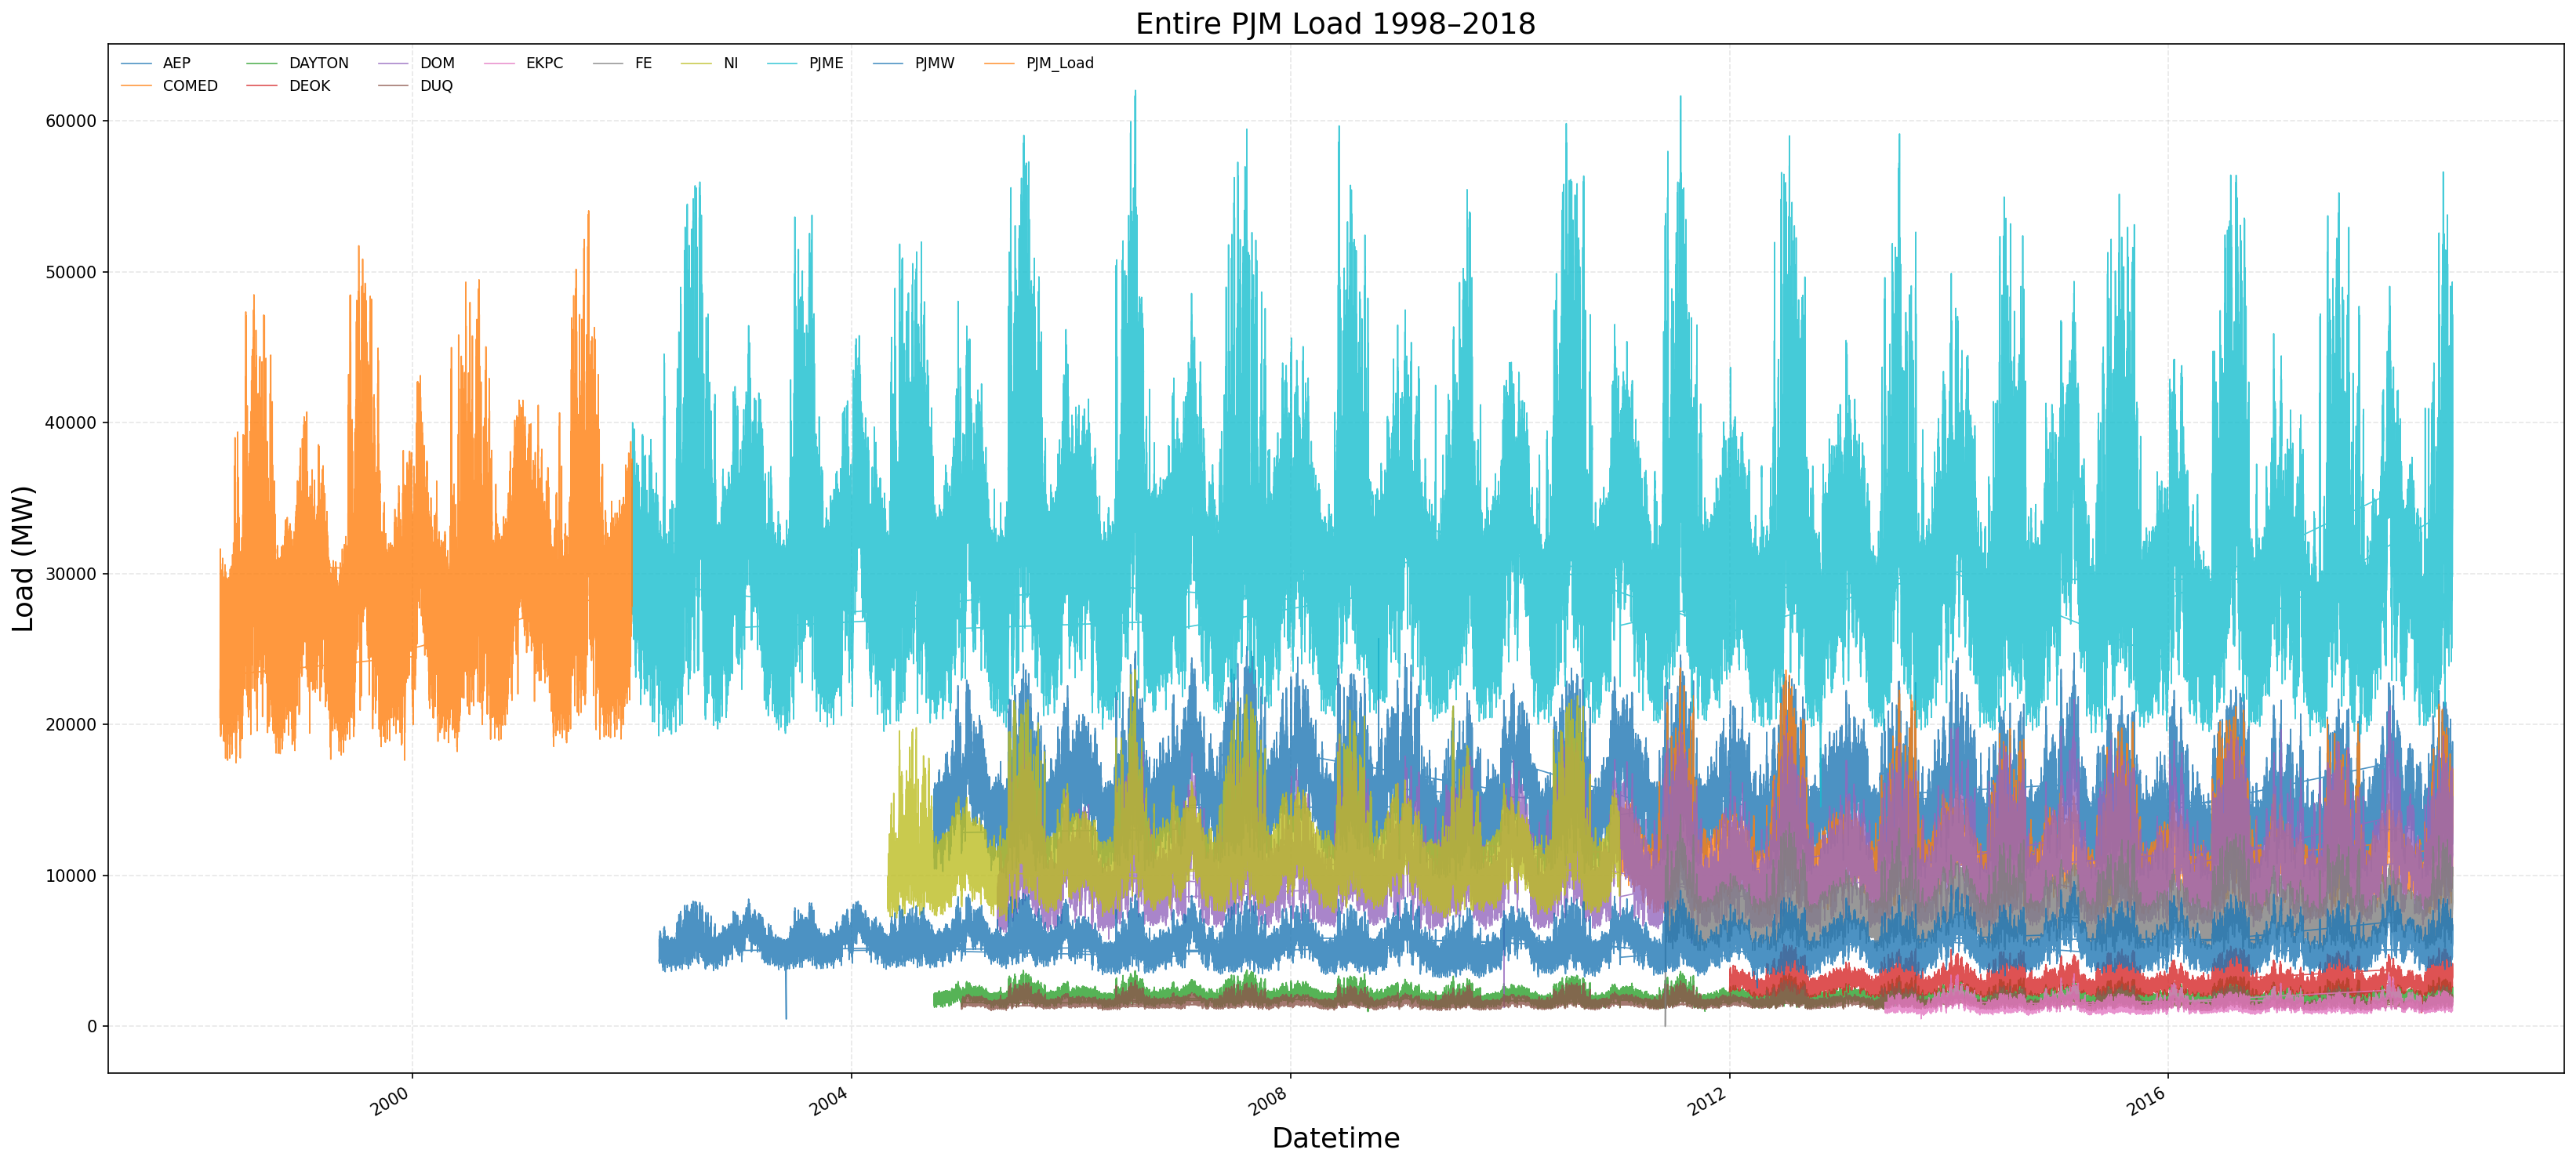

In [74]:
ax = df_all.plot(style='-', lw=0.8, alpha=0.8)

ax.set_title("Entire PJM Load 1998–2018", fontsize=18)
ax.set_xlabel("Datetime", fontsize=17)
ax.set_ylabel("Load (MW)", fontsize=17)
ax.legend(ncol=9, fontsize=9, frameon=False)

plt.tight_layout()
plt.savefig("Entire PJM Load 1998–2018.png", 
            dpi=300, bbox_inches="tight")
plt.show()

In [34]:
# Sanity checks
print("Shape:", df.shape)
print("Index monotonic increasing:", df.index.is_monotonic_increasing)
print("Index inferred freq:", pd.infer_freq(df.index))
print(df.head(5))

Shape: (143232, 2)
Index monotonic increasing: True
Index inferred freq: h
                     East_MW  West_MW
2002-04-01 01:00:00  21734.0   4374.0
2002-04-01 02:00:00  20971.0   4306.0
2002-04-01 03:00:00  20721.0   4322.0
2002-04-01 04:00:00  20771.0   4359.0
2002-04-01 05:00:00  21334.0   4436.0


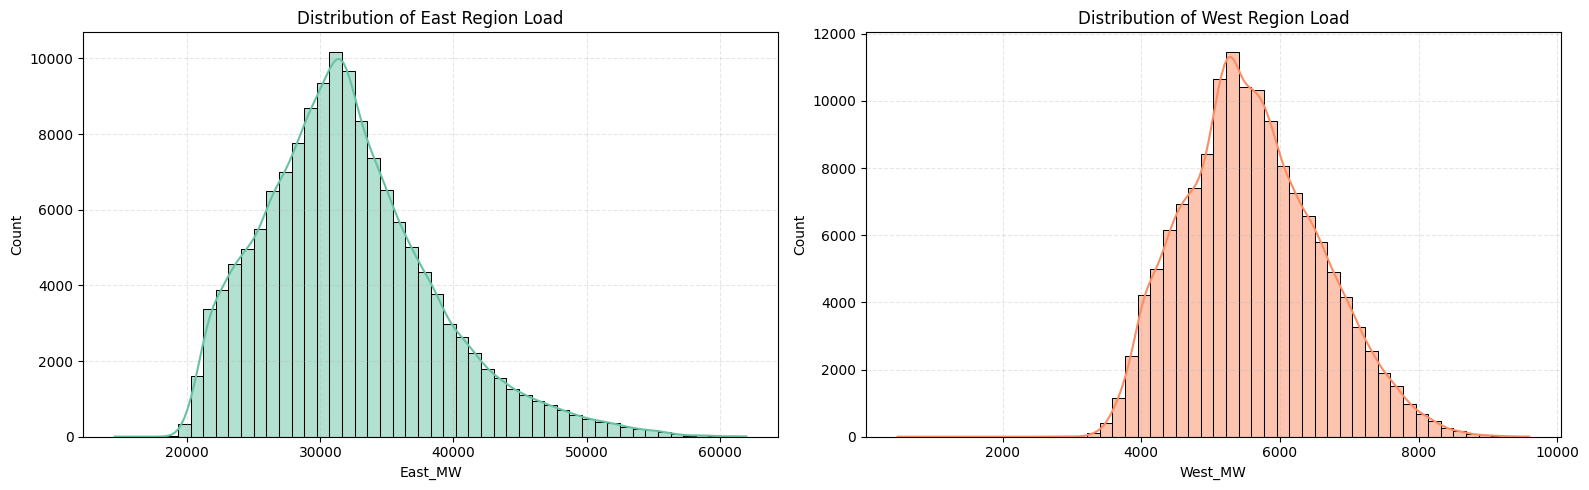

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(df["East_MW"], bins=50, kde=True, ax=ax[0], color=palette[0])
sns.histplot(df["West_MW"], bins=50, kde=True, ax=ax[1], color=palette[1])
ax[0].set_title("Distribution of East Region Load")
ax[1].set_title("Distribution of West Region Load")
plt.tight_layout()
plt.savefig("distribution_east_west.png", 
            dpi=300, bbox_inches="tight")
plt.show()

- **East region load**: Centered around ~32,000 MW, with a long right tail indicating occasional extreme peaks above 60,000 MW.  
- **West region load**: Much smaller in scale (~5,600 MW average) but shows a similar skewed distribution.  
- Both distributions suggest **high variability** and potential seasonality, which justifies further time-series analysis and forecasting.  

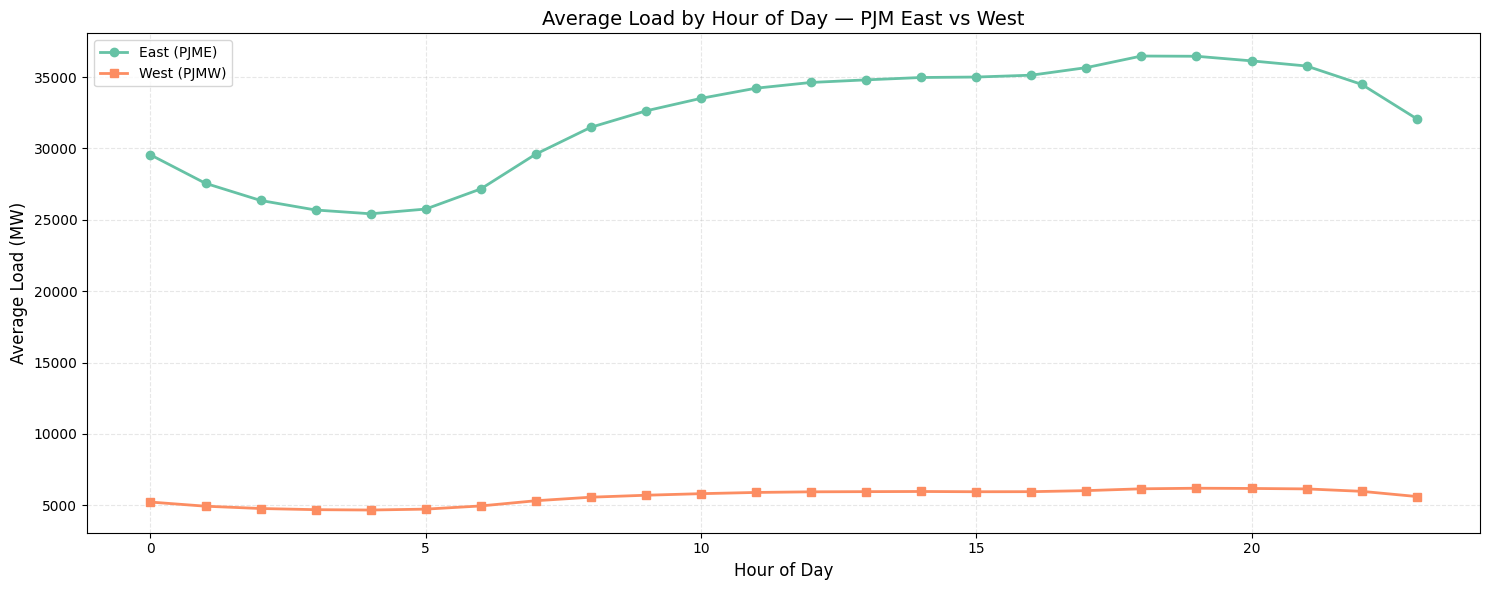

In [54]:
plt.figure(figsize=(15, 6))
colors = sns.color_palette("Set2")

hourly_avg = df.groupby(df.index.hour).mean()
plt.plot(hourly_avg.index, hourly_avg["East_MW"], label="East (PJME)", color=colors[0], linewidth=2, marker='o')
plt.plot(hourly_avg.index, hourly_avg["West_MW"], label="West (PJMW)", color=colors[1], linewidth=2, marker='s')

plt.title("Average Load by Hour of Day — PJM East vs West", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Load (MW)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("Average Load by Hour of Day — PJM East vs West.png", 
            dpi=300, bbox_inches="tight")
plt.show()

**Insight:**  
The chart shows that both PJM East and PJM West experience clear daily demand cycles, with troughs during early morning (3–5 AM) and peaks in the evening (5–8 PM). PJM East consistently carries a much higher load (~6× PJM West), reflecting its larger population and industrial activity.  

**Implication:**  
Understanding these peak patterns is critical for utilities when planning demand response programs, optimizing grid operations, and integrating renewable energy sources. The evening peak, which does not align with solar production, highlights the importance of energy storage or load-shifting measures to ensure grid stability.

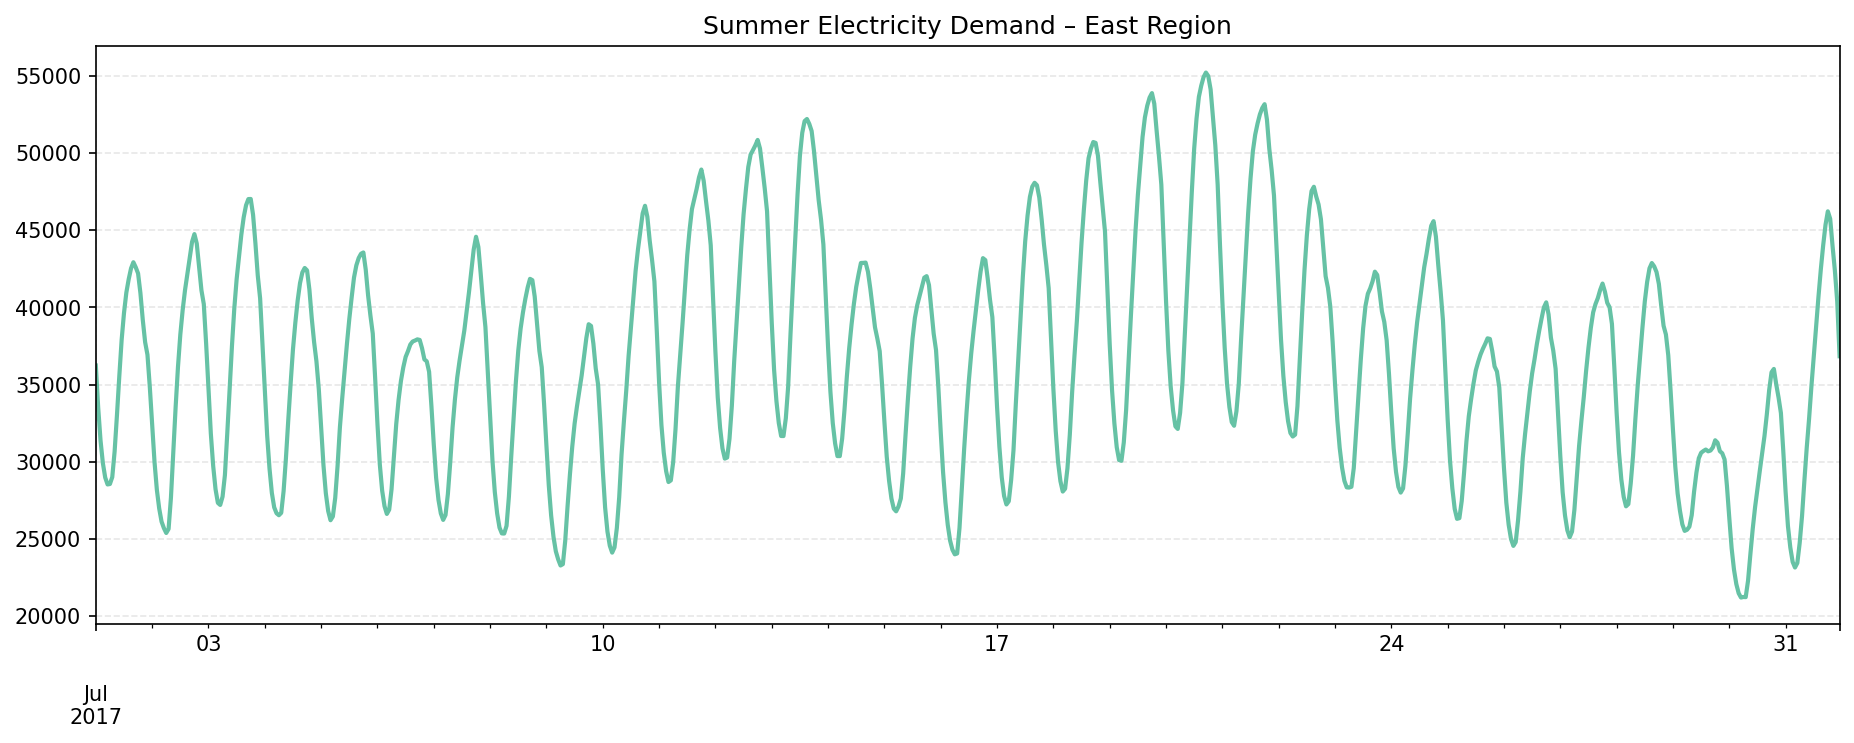

In [88]:
df['East_MW'] \
    .loc[(df['East_MW'].index >= '2017-7-01') & 
         (df['East_MW'].index < '2017-8-01')] \
    .plot(figsize=(15, 5), 
          title='Summer Electricity Demand – East Region', 
          color=palette[0], linewidth=2)
plt.savefig("east_summer_demand.png",
            dpi=300, bbox_inches="tight")

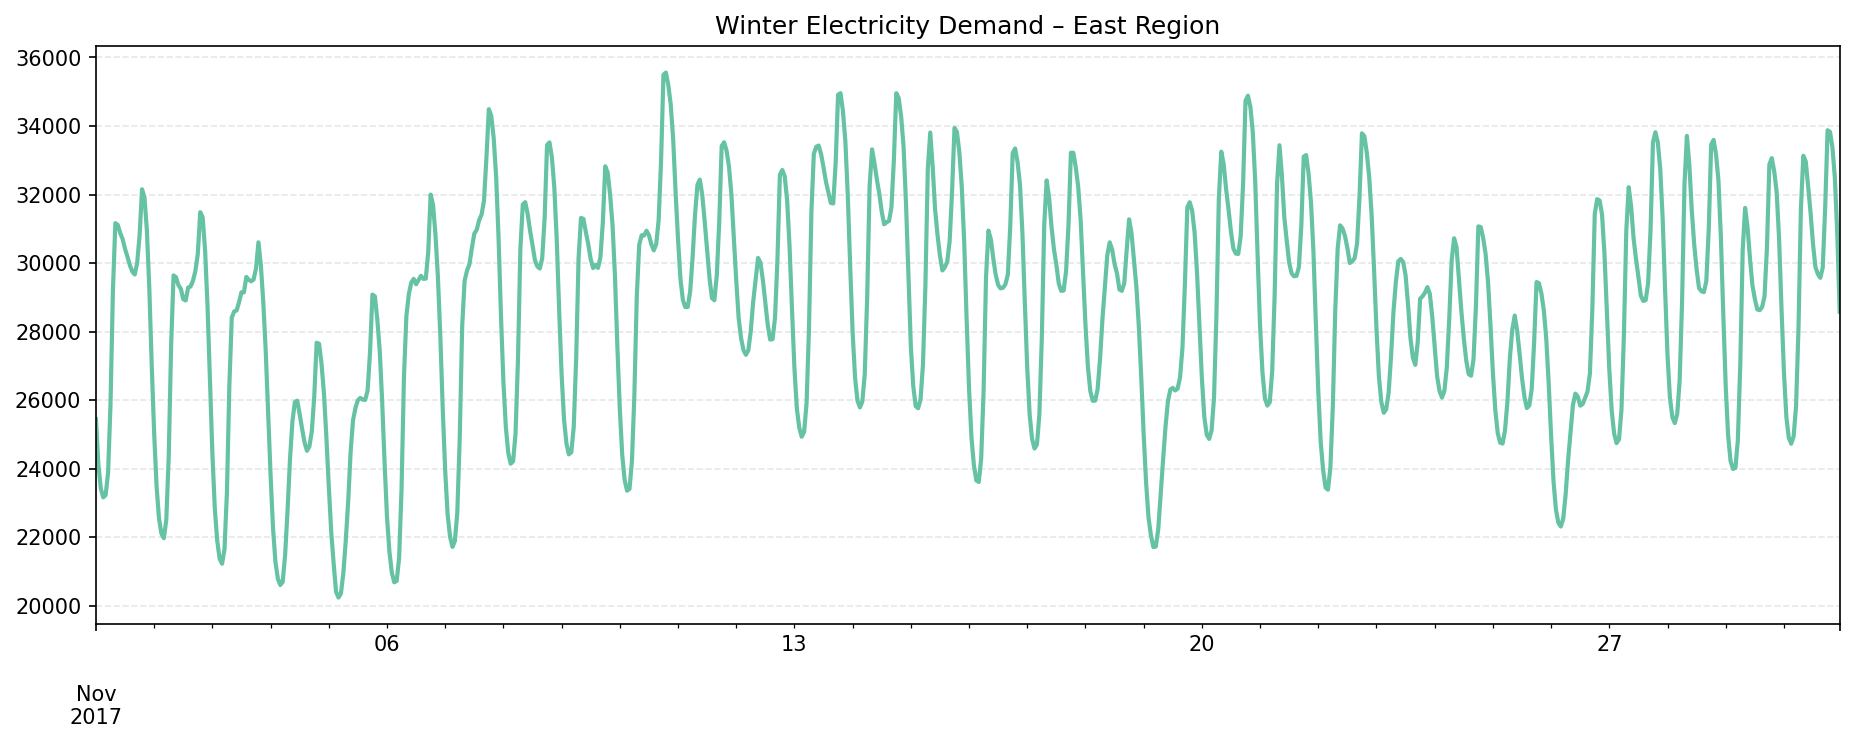

In [89]:
df['East_MW'] \
    .loc[(df['East_MW'].index >= '2017-11-01') & 
         (df['East_MW'].index < '2017-12-01')] \
    .plot(figsize=(15, 5), 
          title='Winter Electricity Demand – East Region', 
          color=palette[0], linewidth=2)
plt.savefig("east_winter_demand.png",
            dpi=300, bbox_inches="tight")

**Higher Summer Peaks:** In July (summer), the East region’s demand spikes above 50,000 MW, much higher than November (winter), which rarely exceeds 36,000 MW.This reflects air conditioning load driving summer peaks.

**Winter Patterns Still Volatile:** November shows daily cycles but at lower magnitudes (20,000–36,000 MW).Peaks are smaller and less extreme, likely tied to heating loads but mitigated by more diverse heating sources (gas, oil, etc.).

## Time Series Forecasting with Machine Learning

In [95]:
def create_features(df, col="East_MW"):
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)

    # Lag and rolling
    df[f"{col}_lag1"] = df[col].shift(1)
    df[f"{col}_lag24"] = df[col].shift(24)
    df[f"{col}_lag168"] = df[col].shift(168)
    df[f"{col}_roll24"] = df[col].rolling(24).mean()
    df[f"{col}_roll168"] = df[col].rolling(168).mean()

    return df.dropna()

In [96]:
# Use last 365 days as test set
n_test = 24 * 365
df_feat = create_features(df[["East_MW"]])
train = df_feat[:-n_test]
test = df_feat[-n_test:]

In [97]:
features = ['hour', 'dayofweek', 'month', 'is_weekend',
            'East_MW_lag1', 'East_MW_lag24', 'East_MW_lag168',
            'East_MW_roll24', 'East_MW_roll168']

X_train, y_train = train[features], train["East_MW"]
X_test, y_test = test[features], test["East_MW"]

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

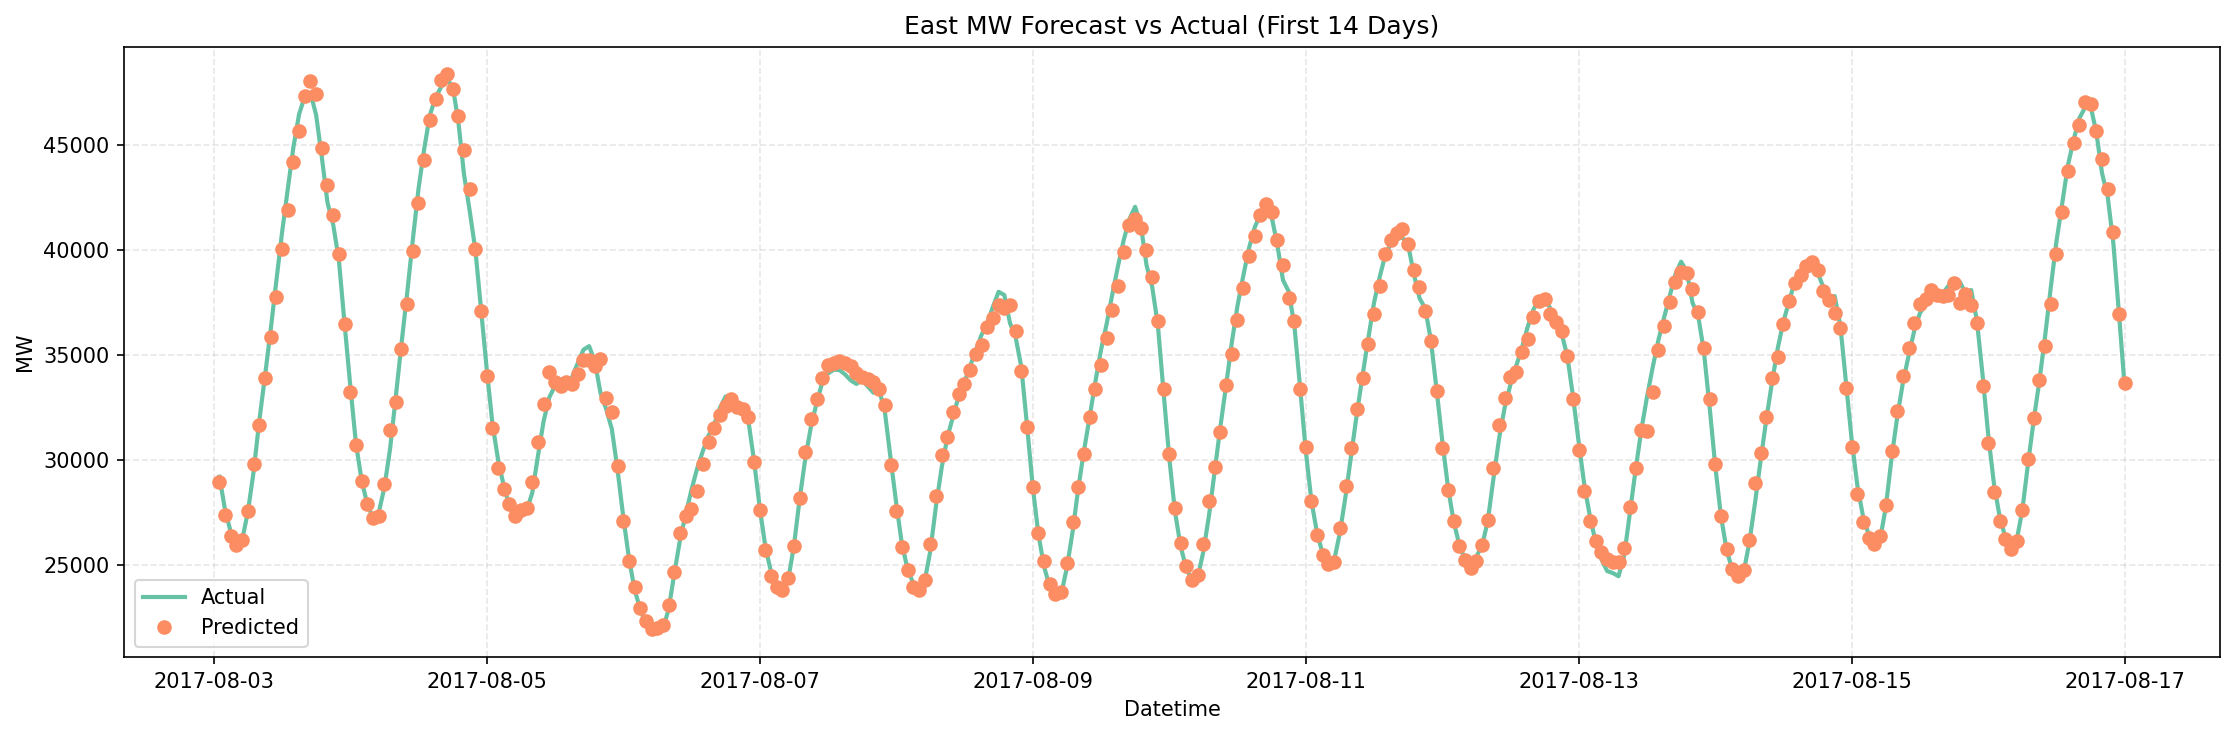

In [99]:
colors = sns.color_palette("Set2")
plt.figure(figsize=(15, 5))

# Plot actual values as green (East color)
plt.plot(y_test.iloc[:24*14], 
         label="Actual", 
         color=colors[0],  # green
         linewidth=2)

# Plot predicted values as orange dots
plt.plot(y_test.index[:24*14], y_pred[:24*14],
         label="Predicted", 
         color=colors[1],  # orange
         marker='o', 
         linestyle='None')

plt.title("East MW Forecast vs Actual (First 14 Days)")
plt.xlabel("Datetime")
plt.ylabel("MW")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [100]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f}")

MAE: 330.85 | RMSE: 451.58 | R²: 0.9944


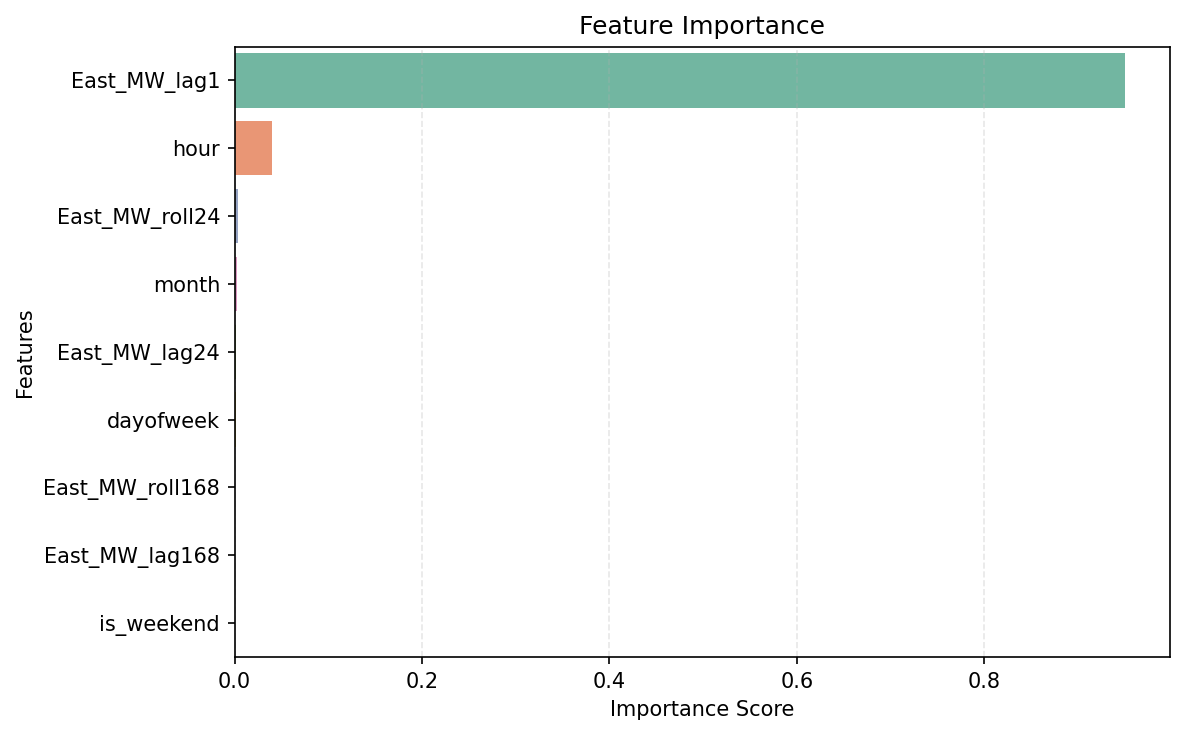

In [102]:
# Example for RandomForestRegressor (adjust to your model)
importances = model.feature_importances_  
features = X_train.columns   # feature names from your dataset

# Put into a DataFrame for clarity
fi_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=fi_df, palette="Set2")
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

**Conclusion:** This machine learning model successfully forecasted electricity demand in the PJM East region with an R² of 0.994, indicating near-perfect fit. Predictions closely tracked actual values across a 14-day test period. Analysis of feature importance revealed that short-term lag variables were the dominant predictors, highlighting the strong autocorrelation structure of electricity load. Secondary predictors like hour of day and month captured cyclical daily and seasonal usage patterns. This demonstrates that the model not only achieves high accuracy but also provides interpretable insights into demand drivers, making it highly relevant for real-world applications in energy load forecasting and grid management. 